# FORMALITIES

In [1]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 33.8 MB/s 
     |████████████████████████████████| 895 kB 31.0 MB/s 
     |████████████████████████████████| 3.3 MB 40.3 MB/s 
     |████████████████████████████████| 596 kB 46.8 MB/s 
     |████████████████████████████████| 59 kB 7.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import subprocess
from ast import literal_eval

def run(command):
    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
    out, err = process.communicate()
    print(out.decode('utf-8').strip())

print('# CPU')
run('cat /proc/cpuinfo | egrep -m 1 "^model name"')
run('cat /proc/cpuinfo | egrep -m 1 "^cpu MHz"')
run('cat /proc/cpuinfo | egrep -m 1 "^cpu cores"')

print('# RAM')
run('cat /proc/meminfo | egrep "^MemTotal"')

print('# GPU')
run('lspci | grep VGA')

print('# OS')
run('uname -a')

# CPU
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
cpu MHz		: 2200.204
cpu cores	: 1
# RAM
MemTotal:       13302916 kB
# GPU

# OS
Linux 00f46c863a75 5.4.104+ #1 SMP Sat Jun 5 09:50:34 PDT 2021 x86_64 x86_64 x86_64 GNU/Linux


In [3]:
import os
import sklearn
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split

import transformers
import tensorflow as tf
# from transformers import *
# import tensorflow_hub as hub
import tensorflow.keras.backend as K
# import bert_tokenization as tokenization

from math import floor, ceil
from scipy.stats import spearmanr

import re 
import string
import seaborn as sns
 
np.set_printoptions(suppress=True)
print(tf.__version__)
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

2.7.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

#LOAD DRIVE

In [4]:
from google.colab import drive
drive.mount('/content/drive')

!ln -s '/content/drive/MyDrive/IE643/' 'IE643'
%cd 'IE643'
!pwd
!ls

Mounted at /content/drive
/content/drive/MyDrive/IE643
/content/drive/MyDrive/IE643
 best_model_colbert_conv     IE643_19D170009_CHALLENGE_ASSIGNMENT
 best_model_col_deeper	    'Python Notebooks'
 best_model_col_deepest      train_embeds
 challenge_dataset	     train_inputs
 ColBERT.ipynb		     train_outputs.npy
'ColBERT Pretrained.ipynb'   val_embeds
 colbert-trained	     val_inputs
 Data			     val_outputs.npy
 IE643


# BERT MODEL AND DATASET

### BERT Tokenizer
Read tokenizer and data, as well as defining the maximum sequence length that will be used for the input to Bert (maximum is usually 512 tokens)

In [5]:
from transformers import BertTokenizer, BertModel

MAX_SEQUENCE_LENGTH = 100
MAX_SENTENCE_LENGTH = 20
MAX_SENTENCES = 5
MODEL_TYPE = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(MODEL_TYPE)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

### Dataset

In [6]:
ls IE643/Data/

dataset.csv  dev.csv  Readme.md  test.csv  train.csv


In [7]:
df = pd.read_csv('IE643/Data/dataset.csv')
df = df[['text','humor']]
print(df)
X = df.iloc[:, 0].values
Y = df.iloc[:, 1].values

print(X)
print(Y)

                                                     text  humor
0       Joe biden rules out 2020 bid: 'guys, i'm not r...  False
1       Watch: darvish gave hitter whiplash with slow ...  False
2       What do you call a turtle without its shell? d...   True
3           5 reasons the 2016 election feels so personal  False
4       Pasco police shot mexican migrant from behind,...  False
...                                                   ...    ...
199995  Conor maynard seamlessly fits old-school r&b h...  False
199996  How to you make holy water? you boil the hell ...   True
199997  How many optometrists does it take to screw in...   True
199998  Mcdonald's will officially kick off all-day br...  False
199999  An irish man walks on the street and ignores a...   True

[200000 rows x 2 columns]
["Joe biden rules out 2020 bid: 'guys, i'm not running'"
 'Watch: darvish gave hitter whiplash with slow pitch'
 'What do you call a turtle without its shell? dead.' ...
 'How many optometrists

In [8]:
df_train = pd.read_csv("IE643/Data/train.csv")
df_val = pd.read_csv("IE643/Data/dev.csv")
df_test = pd.read_csv('IE643/Data/test.csv')

print("Training Dataset -> ")
display(df_train.head())
print("\n\nValidation Dataset -> ")
display(df_val.head())
print("\n\nTest Dataset ->")
display(df_test.head())

print("\n\nTraining entries: {}, Validation entries: {}, Test entries: {}".format(len(df_train), len(df_val), len(df_test)))

Training Dataset -> 


,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind,...",False




Validation Dataset -> 


,text,humor
0,What kind of cat should you take into the des...,True
1,Remember when people used to have to be in sha...,True
2,Pizza is always good. - everyone we'll see abo...,True
3,"What's 6 inches long hard, bent, and in my pan...",True
4,Black teen's response to violence in his commu...,False




Test Dataset ->


,text
0,What kind of cat should you take into the des...
1,Remember when people used to have to be in sha...
2,Pizza is always good. - everyone we'll see abo...
3,"What's 6 inches long hard, bent, and in my pan..."
4,Black teen's response to violence in his commu...




Training entries: 160000, Validation entries: 40000, Test entries: 40000


In [9]:
input_categories = list(df_train.columns[[0]])    
output_categories = list(df_train.columns[1:])
TARGET_COUNT = len(output_categories)

print('Input Categories:\t\t', input_categories)
print('Output Categories:\t\t', output_categories)
print('Number of Model Outputs:\t', TARGET_COUNT)

Input Categories:		 ['text']
Output Categories:		 ['humor']
Number of Model Outputs:	 1


### Data Pre-Processing

In [10]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

def return_id(str1, str2, truncation_strategy, length):

    inputs = tokenizer.encode_plus(str1, str2,
        add_special_tokens=True,
        max_length=length,
        truncation_strategy=truncation_strategy)

    input_ids =  inputs["input_ids"]
    input_masks = [1] * len(input_ids)
    input_segments = inputs["token_type_ids"]
    padding_length = length - len(input_ids)
    padding_id = tokenizer.pad_token_id
    input_ids = input_ids + ([padding_id] * padding_length)
    input_masks = input_masks + ([0] * padding_length)
    input_segments = input_segments + ([0] * padding_length)

    return [input_ids, input_masks, input_segments]


def compute_input_arrays(df, columns, tokenizer):
    model_input = []
    for xx in range((MAX_SENTENCES*3)+3):
        model_input.append([])
    
    for _, row in tqdm(df[columns].iterrows()):
        i = 0
        
        # sent
        sentences = sent_tokenize(row.text)
        # sentences = tokenizer(row.text)
        for xx in range(MAX_SENTENCES):
            s = sentences[xx] if xx<len(sentences) else ''
            ids_q, masks_q, segments_q = return_id(s, None, 'longest_first', MAX_SENTENCE_LENGTH)
            model_input[i].append(ids_q)
            i+=1
            model_input[i].append(masks_q)
            i+=1
            model_input[i].append(segments_q)
            i+=1
        
        # full row
        ids_q, masks_q, segments_q = return_id(row.text, None, 'longest_first', MAX_SEQUENCE_LENGTH)
        model_input[i].append(ids_q)
        i+=1
        model_input[i].append(masks_q)
        i+=1
        model_input[i].append(segments_q)
        
    for xx in range((MAX_SENTENCES*3)+3):
        model_input[xx] = np.asarray(model_input[xx], dtype=np.int32)
    
    print(len(model_input))
    for i in range(len(model_input)):
        print(model_input[i].shape)
    return model_input


def compute_output_arrays(df, columns):
    return np.asarray(df[columns])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [11]:
"""
train_inputs = compute_input_arrays(df_train, input_categories, tokenizer)
val_inputs = compute_input_arrays(df_val, input_categories, tokenizer)
test_inputs = val_inputs

train_outputs = compute_output_arrays(df_train, output_categories)
val_outputs = compute_output_arrays(df_val, output_categories)

os.mkdir('/content/drive/MyDrive/IE643/train_inputs')
os.mkdir('/content/drive/MyDrive/IE643/val_inputs')
%cd 'IE643'

for index in range(len(train_inputs)):
    print(index)
    print(train_inputs[index].shape)
    fname = f'/content/drive/MyDrive/IE643/train_inputs/{index}.npy'
    np.save(fname, np.asarray(train_inputs[index]))

for indey in range(len(val_inputs)):
    print(indey)
    print(val_inputs[indey].shape)
    fname = f'/content/drive/MyDrive/IE643/val_inputs/{indey}.npy'
    np.save(fname, np.asarray(val_inputs[indey]))

np.save('/content/drive/MyDrive/IE643/train_outputs.npy', train_outputs) # save
np.save('/content/drive/MyDrive/IE643/val_outputs.npy', val_outputs) # save
"""
print("Run cell only for the first time.\nUpdate: Read next cell's output.")

Run cell only for the first time.
Update: Read next cell's output.


In [12]:
"""
train_inputs = []
val_inputs = []
idxs = ['train_inputs', 'val_inputs']
for j,name in enumerate(idxs):
    for index in range(3*MAX_SENTENCES + 3):
        fname = f'/content/drive/MyDrive/IE643/{idxs[j]}/{index}.npy'
        if j == 0:
            train_inputs.append(np.load(fname))
        else:
            val_inputs.append(np.load(fname))
test_inputs = val_inputs

train_outputs = np.load('/content/drive/MyDrive/IE643/train_outputs.npy')
val_outputs = np.load('/content/drive/MyDrive/IE643/val_outputs.npy')

variables_list = [train_inputs, val_inputs, test_inputs]
idxs2 = ['train_inputs', 'val_inputs', 'test_inputs']
for idx,variab in enumerate(variables_list):
    print('------------------------------------------------------------')
    print(idxs2[idx])
    print(len(variab))
    for i in range(len(variab)):
        print(variab[i].shape)

idxs3 = ['train outputs', 'validation outputs']
print('------------------------------------------------------------')
for idx, variab in enumerate([train_outputs, val_outputs]):
    print(idxs3[idx])
    print(variab.shape)
print('------------------------------------------------------------')
"""
print("Don't run, embeddings are already stored!")

Don't run, embeddings are already stored!


### BERT Embeddings

In [13]:
import keras.layers as L

"""
def create_model_bert():

    s1_i1 = L.Input((20,), dtype=tf.int32)
    s1_i2 = L.Input((20,), dtype=tf.int32)
    s1_i3 = L.Input((20,), dtype=tf.int32)
    
    s2_i1 = L.Input((20,), dtype=tf.int32)
    s2_i2 = L.Input((20,), dtype=tf.int32)
    s2_i3 = L.Input((20,), dtype=tf.int32)
    
    s3_i1 = L.Input((20,), dtype=tf.int32)
    s3_i2 = L.Input((20,), dtype=tf.int32)
    s3_i3 = L.Input((20,), dtype=tf.int32)
    
    s4_i1 = L.Input((20,), dtype=tf.int32)
    s4_i2 = L.Input((20,), dtype=tf.int32)
    s4_i3 = L.Input((20,), dtype=tf.int32)
    
    s5_i1 = L.Input((20,), dtype=tf.int32)
    s5_i2 = L.Input((20,), dtype=tf.int32)
    s5_i3 = L.Input((20,), dtype=tf.int32)

    sent_i1 = L.Input((100,), dtype=tf.int32)
    sent_i2 = L.Input((100,), dtype=tf.int32)
    sent_i3 = L.Input((100,), dtype=tf.int32)
    
    config = transformers.BertConfig() 
    config.output_hidden_states = False # Set to True to obtain hidden states
    bert_model = transformers.TFBertModel.from_pretrained('bert-base-uncased', config=config)
    for layer in bert_model.layers:
        layer.trainable = False

    s1_embed = bert_model(s1_i1, attention_mask=s1_i2, token_type_ids=s1_i3)[0]
    s2_embed = bert_model(s2_i1, attention_mask=s2_i2, token_type_ids=s2_i3)[0]
    s3_embed = bert_model(s3_i1, attention_mask=s3_i2, token_type_ids=s3_i3)[0]
    s4_embed = bert_model(s4_i1, attention_mask=s4_i2, token_type_ids=s4_i3)[0]
    s5_embed = bert_model(s5_i1, attention_mask=s5_i2, token_type_ids=s5_i3)[0]
    sent_embed = bert_model(sent_i1, attention_mask=sent_i2, token_type_ids=sent_i3)[0]

    s1 = L.GlobalAveragePooling1D()(s1_embed)
    s2 = L.GlobalAveragePooling1D()(s2_embed)
    s3 = L.GlobalAveragePooling1D()(s3_embed)
    s4 = L.GlobalAveragePooling1D()(s4_embed)
    s5 = L.GlobalAveragePooling1D()(s5_embed)
    sentence = L.GlobalAveragePooling1D()(sent_embed)
    
    model = tf.keras.models.Model(inputs=[s1_i1, s1_i2, s1_i3, s2_i1, s2_i2, s2_i3, s3_i1, s3_i2, s3_i3, s4_i1, s4_i2, s4_i3,  s5_i1, s5_i2, s5_i3, sent_i1, sent_i2, sent_i3], outputs = [s1, s2, s3, s4, s5, sentence])
    # tf.keras.utils.plot_model(model, to_file="/content/my_model.png", show_shapes=True,  show_layer_names=False)
    print('\n\n________________________________________________________________________________________________________________________________________________________________________________________________________________________________________\n')
    model.summary()
    return model

bert_model_intermediate =  create_model_bert()

train_embeds = bert_model_intermediate.predict(train_inputs)
for index in range(len(train_embeds)):
    print(index)
    print(train_embeds[index].shape)
    fname = f'/content/drive/MyDrive/IE643/train_embeds/{index}.npy'
    np.save(fname, np.asarray(train_embeds[index]))

val_embeds = bert_model_intermediate.predict(val_inputs)
for index in range(len(val_embeds)):
    print(index)
    print(val_embeds[index].shape)
    fname = f'/content/drive/MyDrive/IE643/val_embeds/{index}.npy'
    np.save(fname, np.asarray(val_embeds[index]))
"""
print()

In [14]:
train_embeds = []
val_embeds = []
idxs = ['train_embeds', 'val_embeds']
for j,name in enumerate(idxs):
    for index in range(6):
        fname = f'/content/drive/MyDrive/IE643/{idxs[j]}/{index}.npy'
        if j == 0:
            train_embeds.append(np.load(fname))
        else:
            val_embeds.append(np.load(fname))
test_embeds = val_embeds

train_outputs = np.load('/content/drive/MyDrive/IE643/train_outputs.npy')
val_outputs = np.load('/content/drive/MyDrive/IE643/val_outputs.npy')

variables_list = [train_embeds, val_embeds, test_embeds]
idxs2 = ['train_embeds', 'val_embeds', 'test_embeds']
for idx,variab in enumerate(variables_list):
    print('------------------------------------------------------------')
    print(idxs2[idx])
    print(len(variab))
    for i in range(len(variab)):
        print(variab[i].shape)

idxs3 = ['train outputs', 'validation outputs']
print('------------------------------------------------------------')
for idx, variab in enumerate([train_outputs, val_outputs]):
    print(idxs3[idx])
    print(variab.shape)
print('------------------------------------------------------------')

------------------------------------------------------------
train_embeds
6
(160000, 768)
(160000, 768)
(160000, 768)
(160000, 768)
(160000, 768)
(160000, 768)
------------------------------------------------------------
val_embeds
6
(40000, 768)
(40000, 768)
(40000, 768)
(40000, 768)
(40000, 768)
(40000, 768)
------------------------------------------------------------
test_embeds
6
(40000, 768)
(40000, 768)
(40000, 768)
(40000, 768)
(40000, 768)
(40000, 768)
------------------------------------------------------------
train outputs
(160000, 1)
validation outputs
(40000, 1)
------------------------------------------------------------


# COLBERT MODEL
`create_model_<name>()` functions contain the architecture that will be used to make the ColBERT extension, as well as the project improvement extension to BERT.


### Models with BERT, using BERT tokens as features

In [15]:
import keras.layers as L

def create_model_colbert_dense():

    s1_i1 = L.Input((20,), dtype=tf.int32)
    s1_i2 = L.Input((20,), dtype=tf.int32)
    s1_i3 = L.Input((20,), dtype=tf.int32)
    
    s2_i1 = L.Input((20,), dtype=tf.int32)
    s2_i2 = L.Input((20,), dtype=tf.int32)
    s2_i3 = L.Input((20,), dtype=tf.int32)
    
    s3_i1 = L.Input((20,), dtype=tf.int32)
    s3_i2 = L.Input((20,), dtype=tf.int32)
    s3_i3 = L.Input((20,), dtype=tf.int32)
    
    s4_i1 = L.Input((20,), dtype=tf.int32)
    s4_i2 = L.Input((20,), dtype=tf.int32)
    s4_i3 = L.Input((20,), dtype=tf.int32)
    
    s5_i1 = L.Input((20,), dtype=tf.int32)
    s5_i2 = L.Input((20,), dtype=tf.int32)
    s5_i3 = L.Input((20,), dtype=tf.int32)

    sent_i1 = L.Input((100,), dtype=tf.int32)
    sent_i2 = L.Input((100,), dtype=tf.int32)
    sent_i3 = L.Input((100,), dtype=tf.int32)
    
    
    config = transformers.BertConfig() 
    config.output_hidden_states = False # Set to True to obtain hidden states
    bert_model = transformers.TFBertModel.from_pretrained('bert-base-uncased', config=config)
    for layer in bert_model.layers:
        layer.trainable = False

    s1_embed = bert_model(s1_i1, attention_mask=s1_i2, token_type_ids=s1_i3)[0]
    s2_embed = bert_model(s2_i1, attention_mask=s2_i2, token_type_ids=s2_i3)[0]
    s3_embed = bert_model(s3_i1, attention_mask=s3_i2, token_type_ids=s3_i3)[0]
    s4_embed = bert_model(s4_i1, attention_mask=s4_i2, token_type_ids=s4_i3)[0]
    s5_embed = bert_model(s5_i1, attention_mask=s5_i2, token_type_ids=s5_i3)[0]
    sent_embed = bert_model(sent_i1, attention_mask=sent_i2, token_type_ids=sent_i3)[0]

    s1 = L.GlobalAveragePooling1D()(s1_embed)
    s2 = L.GlobalAveragePooling1D()(s2_embed)
    s3 = L.GlobalAveragePooling1D()(s3_embed)
    s4 = L.GlobalAveragePooling1D()(s4_embed)
    s5 = L.GlobalAveragePooling1D()(s5_embed)
    sentence = L.GlobalAveragePooling1D()(sent_embed)

    s1_dense = L.Dense(32, activation='relu')(s1)
    s2_dense = L.Dense(32, activation='relu')(s2)
    s3_dense = L.Dense(32, activation='relu')(s3)
    s4_dense = L.Dense(32, activation='relu')(s4)
    s5_dense = L.Dense(32, activation='relu')(s5)
    sent_dense = L.Dense(256, activation='relu')(sentence)
    
    s1_dense_drop = L.Dropout(0.2)(s1_dense)
    s2_dense_drop = L.Dropout(0.2)(s2_dense)
    s3_dense_drop = L.Dropout(0.2)(s3_dense)
    s4_dense_drop = L.Dropout(0.2)(s4_dense)
    s5_dense_drop = L.Dropout(0.2)(s5_dense)
    sent_dense_drop = L.Dropout(0.2)(sent_dense)

    s1_dense_2 = L.Dense(8, activation='relu')(s1_dense_drop)
    s2_dense_2 = L.Dense(8, activation='relu')(s2_dense_drop)
    s3_dense_2 = L.Dense(8, activation='relu')(s3_dense_drop)
    s4_dense_2 = L.Dense(8, activation='relu')(s4_dense_drop)
    s5_dense_2 = L.Dense(8, activation='relu')(s5_dense_drop)
    sent_dense_2 = L.Dense(64, activation='relu')(sent_dense_drop)
    
    sent_concat = L.concatenate([s1_dense_2, s2_dense_2, s3_dense_2, s4_dense_2, s5_dense_2, sent_dense_2])
    
    x = L.Dense(512, activation='relu')(sent_concat)
    x = L.Dropout(0.2)(x)   
    x = L.Dense(256, activation='relu')(x)
    x = L.Dense(TARGET_COUNT, activation='sigmoid')(x)
    
    model = tf.keras.models.Model(inputs=[s1_i1, s1_i2, s1_i3, s2_i1, s2_i2, s2_i3, s3_i1, s3_i2, s3_i3, s4_i1, s4_i2, s4_i3,  s5_i1, s5_i2, s5_i3, sent_i1, sent_i2, sent_i3], outputs = x)
    tf.keras.utils.plot_model(model, to_file="/content/my_model.png", show_shapes=True,  show_layer_names=False)
    print('\n\n________________________________________________________________________________________________________________________________________________________________________________________________________________________________________\n')
    model.summary()
    return model

def create_model_colbert_conv():
    
    s1_i1 = L.Input((20,), dtype=tf.int32)
    s1_i2 = L.Input((20,), dtype=tf.int32)
    s1_i3 = L.Input((20,), dtype=tf.int32)
    
    s2_i1 = L.Input((20,), dtype=tf.int32)
    s2_i2 = L.Input((20,), dtype=tf.int32)
    s2_i3 = L.Input((20,), dtype=tf.int32)
    
    s3_i1 = L.Input((20,), dtype=tf.int32)
    s3_i2 = L.Input((20,), dtype=tf.int32)
    s3_i3 = L.Input((20,), dtype=tf.int32)
    
    s4_i1 = L.Input((20,), dtype=tf.int32)
    s4_i2 = L.Input((20,), dtype=tf.int32)
    s4_i3 = L.Input((20,), dtype=tf.int32)
    
    s5_i1 = L.Input((20,), dtype=tf.int32)
    s5_i2 = L.Input((20,), dtype=tf.int32)
    s5_i3 = L.Input((20,), dtype=tf.int32)

    sent_i1 = L.Input((100,), dtype=tf.int32)
    sent_i2 = L.Input((100,), dtype=tf.int32)
    sent_i3 = L.Input((100,), dtype=tf.int32)
    
    
    config = transformers.BertConfig() 
    config.output_hidden_states = False # Set to True to obtain hidden states
    bert_model = transformers.TFBertModel.from_pretrained('bert-base-uncased', config=config)
    for layer in bert_model.layers:
        layer.trainable = False

    s1_embed = bert_model(s1_i1, attention_mask=s1_i2, token_type_ids=s1_i3)[0]
    s2_embed = bert_model(s2_i1, attention_mask=s2_i2, token_type_ids=s2_i3)[0]
    s3_embed = bert_model(s3_i1, attention_mask=s3_i2, token_type_ids=s3_i3)[0]
    s4_embed = bert_model(s4_i1, attention_mask=s4_i2, token_type_ids=s4_i3)[0]
    s5_embed = bert_model(s5_i1, attention_mask=s5_i2, token_type_ids=s5_i3)[0]
    sent_embed = bert_model(sent_i1, attention_mask=sent_i2, token_type_ids=sent_i3)[0]

    s1 = L.GlobalAveragePooling1D()(s1_embed)
    s2 = L.GlobalAveragePooling1D()(s2_embed)
    s3 = L.GlobalAveragePooling1D()(s3_embed)
    s4 = L.GlobalAveragePooling1D()(s4_embed)
    s5 = L.GlobalAveragePooling1D()(s5_embed)
    sentence = L.GlobalAveragePooling1D()(sent_embed)

    s1 = L.Reshape((768,-1))(s1)
    s2 = L.Reshape((768,-1))(s2)
    s3 = L.Reshape((768,-1))(s3)
    s4 = L.Reshape((768,-1))(s4)
    s5 = L.Reshape((768,-1))(s5)
    sentence = L.Reshape((768,-1))(sentence)

    dropout_val = 0.4

    s1_conv1 = L.Conv1D(1, int(768/16), activation = 'relu', padding = 'same')(s1)
    s1_conv1 = L.Dropout(dropout_val)(s1_conv1)
    s2_conv1 = L.Conv1D(1, int(768/16), activation = 'relu', padding = 'same')(s2)
    s2_conv1 = L.Dropout(dropout_val)(s2_conv1)
    s3_conv1 = L.Conv1D(1, int(768/16), activation = 'relu', padding = 'same')(s3)
    s3_conv1 = L.Dropout(dropout_val)(s3_conv1)
    s4_conv1 = L.Conv1D(1, int(768/16), activation = 'relu', padding = 'same')(s4)
    s4_conv1 = L.Dropout(dropout_val)(s4_conv1)
    s5_conv1 = L.Conv1D(1, int(768/16), activation = 'relu', padding = 'same')(s5)
    s5_conv1 = L.Dropout(dropout_val)(s5_conv1)
    sent_conv1 = L.Conv1D(1, int(768/32), activation = 'relu', padding = 'same')(sentence)
    sent_conv1 = L.Dropout(dropout_val)(sent_conv1)

    s1_pool1 = L.MaxPooling1D(4, padding='valid')(s1_conv1)
    s2_pool1 = L.MaxPooling1D(4, padding='valid')(s2_conv1)
    s3_pool1 = L.MaxPooling1D(4, padding='valid')(s3_conv1)
    s4_pool1 = L.MaxPooling1D(4, padding='valid')(s4_conv1)
    s5_pool1 = L.MaxPooling1D(4, padding='valid')(s5_conv1)
    sent_pool1 = L.MaxPooling1D(2, padding='valid')(sent_conv1)

    s1_conv2 = L.Conv1D(1, int(192/16), activation = 'relu', padding = 'same')(s1_pool1)
    s1_conv2 = L.Dropout(dropout_val)(s1_conv2)
    s2_conv2 = L.Conv1D(1, int(192/16), activation = 'relu', padding = 'same')(s2_pool1)
    s2_conv2 = L.Dropout(dropout_val)(s2_conv2)
    s3_conv2 = L.Conv1D(1, int(192/16), activation = 'relu', padding = 'same')(s3_pool1)
    s3_conv2 = L.Dropout(dropout_val)(s3_conv2)
    s4_conv2 = L.Conv1D(1, int(192/16), activation = 'relu', padding = 'same')(s4_pool1)
    s4_conv2 = L.Dropout(dropout_val)(s4_conv2)
    s5_conv2 = L.Conv1D(1, int(192/16), activation = 'relu', padding = 'same')(s5_pool1)
    s5_conv2 = L.Dropout(dropout_val)(s5_conv2)
    sent_conv2 = L.Conv1D(1, int(192/32), activation = 'relu', padding = 'same')(sent_pool1)
    sent_conv2 = L.Dropout(dropout_val)(sent_conv2)

    s1_pool2 = L.MaxPooling1D(4, padding='valid')(s1_conv2)
    s2_pool2 = L.MaxPooling1D(4, padding='valid')(s2_conv2)
    s3_pool2 = L.MaxPooling1D(4, padding='valid')(s3_conv2)
    s4_pool2 = L.MaxPooling1D(4, padding='valid')(s4_conv2)
    s5_pool2 = L.MaxPooling1D(4, padding='valid')(s5_conv2)
    sent_pool2 = L.MaxPooling1D(2, padding='valid')(sent_conv2)

    s1_conv3 = L.Conv1D(1, int(48/16), activation = 'relu', padding = 'same')(s1_pool2)
    s1_conv3 = L.Dropout(dropout_val)(s1_conv3)
    s2_conv3 = L.Conv1D(1, int(48/16), activation = 'relu', padding = 'same')(s2_pool2)
    s2_conv3 = L.Dropout(dropout_val)(s2_conv3)
    s3_conv3 = L.Conv1D(1, int(48/16), activation = 'relu', padding = 'same')(s3_pool2)
    s3_conv3 = L.Dropout(dropout_val)(s3_conv3)
    s4_conv3 = L.Conv1D(1, int(48/16), activation = 'relu', padding = 'same')(s4_pool2)
    s4_conv3 = L.Dropout(dropout_val)(s4_conv3)
    s5_conv3 = L.Conv1D(1, int(48/16), activation = 'relu', padding = 'same')(s5_pool2)
    s5_conv3 = L.Dropout(dropout_val)(s5_conv3)
    sent_conv3 = L.Conv1D(1, int(48/24), activation = 'relu', padding = 'same')(sent_pool2)
    sent_conv3 = L.Dropout(dropout_val)(sent_conv3)

    s1_pool3 = L.MaxPooling1D(4, padding='valid')(s1_conv3)
    s2_pool3 = L.MaxPooling1D(4, padding='valid')(s2_conv3)
    s3_pool3 = L.MaxPooling1D(4, padding='valid')(s3_conv3)
    s4_pool3 = L.MaxPooling1D(4, padding='valid')(s4_conv3)
    s5_pool3 = L.MaxPooling1D(4, padding='valid')(s5_conv3)
    sent_pool3 = L.MaxPooling1D(2, padding='valid')(sent_conv3)
    
    sent_concat = L.concatenate([s1_pool3, s2_pool3, s3_pool3, s4_pool3, s5_pool3, sent_pool3], axis = 1)

    x = L.Conv1D(1, 49, activation = 'relu', padding = 'valid')(sent_concat)
    x = L.Dropout(0.2)(x)
    x = L.Conv1D(1, 108, activation = 'sigmoid', padding = 'valid')(x)
    x = L.Flatten()(x)

    model = tf.keras.models.Model(inputs=[s1_i1, s1_i2, s1_i3, s2_i1, s2_i2, s2_i3, s3_i1, s3_i2, s3_i3, s4_i1, s4_i2, s4_i3,  s5_i1, s5_i2, s5_i3, sent_i1, sent_i2, sent_i3], outputs = x)
    tf.keras.utils.plot_model(model, to_file="/content/my_model.png", show_shapes=True,  show_layer_names=False)
    print('\n\n________________________________________________________________________________________________________________________________________________________________________________________________________________________________________\n')
    model.summary()
    return model

# net0 = create_model_colbert_dense()
# net = create_model_colbert_conv()

###Models without BERT, using BERT embeddings as features

In [16]:
import keras.layers as L

def create_model_col_dense():

    s1 = L.Input((768,), dtype=tf.float32)
    s2 = L.Input((768,), dtype=tf.float32)
    s3 = L.Input((768,), dtype=tf.float32)
    s4 = L.Input((768,), dtype=tf.float32)
    s5 = L.Input((768,), dtype=tf.float32)
    sentence = L.Input((768,), dtype=tf.float32)

    s1_dense = L.Dense(32, activation='relu')(s1)
    s2_dense = L.Dense(32, activation='relu')(s2)
    s3_dense = L.Dense(32, activation='relu')(s3)
    s4_dense = L.Dense(32, activation='relu')(s4)
    s5_dense = L.Dense(32, activation='relu')(s5)
    sent_dense = L.Dense(256, activation='relu')(sentence)
    
    s1_dense_drop = L.Dropout(0.2)(s1_dense)
    s2_dense_drop = L.Dropout(0.2)(s2_dense)
    s3_dense_drop = L.Dropout(0.2)(s3_dense)
    s4_dense_drop = L.Dropout(0.2)(s4_dense)
    s5_dense_drop = L.Dropout(0.2)(s5_dense)
    sent_dense_drop = L.Dropout(0.2)(sent_dense)

    s1_dense_2 = L.Dense(8, activation='relu')(s1_dense_drop)
    s2_dense_2 = L.Dense(8, activation='relu')(s2_dense_drop)
    s3_dense_2 = L.Dense(8, activation='relu')(s3_dense_drop)
    s4_dense_2 = L.Dense(8, activation='relu')(s4_dense_drop)
    s5_dense_2 = L.Dense(8, activation='relu')(s5_dense_drop)
    sent_dense_2 = L.Dense(64, activation='relu')(sent_dense_drop)
    
    sent_concat = L.concatenate([s1_dense_2, s2_dense_2, s3_dense_2, s4_dense_2, s5_dense_2, sent_dense_2])
    
    x = L.Dense(512, activation='relu')(sent_concat)
    x = L.Dropout(0.2)(x)   
    x = L.Dense(256, activation='relu')(x)
    x = L.Dense(TARGET_COUNT, activation='sigmoid')(x)
    
    model = tf.keras.models.Model(inputs=[s1, s2, s3, s4, s5, sentence], outputs = x)
    tf.keras.utils.plot_model(model, to_file="/content/my_model.png", show_shapes=True,  show_layer_names=False)
    print('\n\n________________________________________________________________________________________________________________________________________________________________________________________________________________________________________\n')
    model.summary()
    return model

def create_model_col_conv():
    
    s1 = L.Input((768,), dtype=tf.float32)
    s2 = L.Input((768,), dtype=tf.float32)
    s3 = L.Input((768,), dtype=tf.float32)
    s4 = L.Input((768,), dtype=tf.float32)
    s5 = L.Input((768,), dtype=tf.float32)
    sentence = L.Input((768,), dtype=tf.float32)
    
    s1 = L.Reshape((768,-1))(s1)
    s2 = L.Reshape((768,-1))(s2)
    s3 = L.Reshape((768,-1))(s3)
    s4 = L.Reshape((768,-1))(s4)
    s5 = L.Reshape((768,-1))(s5)
    sentence = L.Reshape((768,-1))(sentence)

    dropout_val = 0.4

    s1_conv1 = L.Conv1D(1, int(768/16), activation = 'relu', padding = 'same')(s1)
    s1_conv1 = L.Dropout(dropout_val)(s1_conv1)
    s2_conv1 = L.Conv1D(1, int(768/16), activation = 'relu', padding = 'same')(s2)
    s2_conv1 = L.Dropout(dropout_val)(s2_conv1)
    s3_conv1 = L.Conv1D(1, int(768/16), activation = 'relu', padding = 'same')(s3)
    s3_conv1 = L.Dropout(dropout_val)(s3_conv1)
    s4_conv1 = L.Conv1D(1, int(768/16), activation = 'relu', padding = 'same')(s4)
    s4_conv1 = L.Dropout(dropout_val)(s4_conv1)
    s5_conv1 = L.Conv1D(1, int(768/16), activation = 'relu', padding = 'same')(s5)
    s5_conv1 = L.Dropout(dropout_val)(s5_conv1)
    sent_conv1 = L.Conv1D(1, int(768/32), activation = 'relu', padding = 'same')(sentence)
    sent_conv1 = L.Dropout(dropout_val)(sent_conv1)

    s1_pool1 = L.MaxPooling1D(4, padding='valid')(s1_conv1)
    s2_pool1 = L.MaxPooling1D(4, padding='valid')(s2_conv1)
    s3_pool1 = L.MaxPooling1D(4, padding='valid')(s3_conv1)
    s4_pool1 = L.MaxPooling1D(4, padding='valid')(s4_conv1)
    s5_pool1 = L.MaxPooling1D(4, padding='valid')(s5_conv1)
    sent_pool1 = L.MaxPooling1D(2, padding='valid')(sent_conv1)

    s1_conv2 = L.Conv1D(1, int(192/16), activation = 'relu', padding = 'same')(s1_pool1)
    s1_conv2 = L.Dropout(dropout_val)(s1_conv2)
    s2_conv2 = L.Conv1D(1, int(192/16), activation = 'relu', padding = 'same')(s2_pool1)
    s2_conv2 = L.Dropout(dropout_val)(s2_conv2)
    s3_conv2 = L.Conv1D(1, int(192/16), activation = 'relu', padding = 'same')(s3_pool1)
    s3_conv2 = L.Dropout(dropout_val)(s3_conv2)
    s4_conv2 = L.Conv1D(1, int(192/16), activation = 'relu', padding = 'same')(s4_pool1)
    s4_conv2 = L.Dropout(dropout_val)(s4_conv2)
    s5_conv2 = L.Conv1D(1, int(192/16), activation = 'relu', padding = 'same')(s5_pool1)
    s5_conv2 = L.Dropout(dropout_val)(s5_conv2)
    sent_conv2 = L.Conv1D(1, int(192/32), activation = 'relu', padding = 'same')(sent_pool1)
    sent_conv2 = L.Dropout(dropout_val)(sent_conv2)

    s1_pool2 = L.MaxPooling1D(4, padding='valid')(s1_conv2)
    s2_pool2 = L.MaxPooling1D(4, padding='valid')(s2_conv2)
    s3_pool2 = L.MaxPooling1D(4, padding='valid')(s3_conv2)
    s4_pool2 = L.MaxPooling1D(4, padding='valid')(s4_conv2)
    s5_pool2 = L.MaxPooling1D(4, padding='valid')(s5_conv2)
    sent_pool2 = L.MaxPooling1D(2, padding='valid')(sent_conv2)

    s1_conv3 = L.Conv1D(1, int(48/16), activation = 'relu', padding = 'same')(s1_pool2)
    s1_conv3 = L.Dropout(dropout_val)(s1_conv3)
    s2_conv3 = L.Conv1D(1, int(48/16), activation = 'relu', padding = 'same')(s2_pool2)
    s2_conv3 = L.Dropout(dropout_val)(s2_conv3)
    s3_conv3 = L.Conv1D(1, int(48/16), activation = 'relu', padding = 'same')(s3_pool2)
    s3_conv3 = L.Dropout(dropout_val)(s3_conv3)
    s4_conv3 = L.Conv1D(1, int(48/16), activation = 'relu', padding = 'same')(s4_pool2)
    s4_conv3 = L.Dropout(dropout_val)(s4_conv3)
    s5_conv3 = L.Conv1D(1, int(48/16), activation = 'relu', padding = 'same')(s5_pool2)
    s5_conv3 = L.Dropout(dropout_val)(s5_conv3)
    sent_conv3 = L.Conv1D(1, int(48/24), activation = 'relu', padding = 'same')(sent_pool2)
    sent_conv3 = L.Dropout(dropout_val)(sent_conv3)

    s1_pool3 = L.MaxPooling1D(4, padding='valid')(s1_conv3)
    s2_pool3 = L.MaxPooling1D(4, padding='valid')(s2_conv3)
    s3_pool3 = L.MaxPooling1D(4, padding='valid')(s3_conv3)
    s4_pool3 = L.MaxPooling1D(4, padding='valid')(s4_conv3)
    s5_pool3 = L.MaxPooling1D(4, padding='valid')(s5_conv3)
    sent_pool3 = L.MaxPooling1D(2, padding='valid')(sent_conv3)
    
    sent_concat = L.concatenate([s1_pool3, s2_pool3, s3_pool3, s4_pool3, s5_pool3, sent_pool3], axis = 1)

    x = L.Conv1D(1, 49, activation = 'relu', padding = 'valid')(sent_concat)
    x = L.Dropout(0.2)(x)
    x = L.Conv1D(1, 108, activation = 'sigmoid', padding = 'valid')(x)
    x = L.Flatten()(x)

    model = tf.keras.models.Model(inputs=[s1, s2, s3, s4, s5, sentence], outputs = x)
    tf.keras.utils.plot_model(model, to_file="/content/my_model.png", show_shapes=True,  show_layer_names=False)
    print('\n\n________________________________________________________________________________________________________________________________________________________________________________________________________________________________________\n')
    model.summary()
    return model

# net_ = create_model_col_conv()
# net__ = create_model_col_dense()

In [17]:
def create_model_col_conv_deeper():
    
    s1 = L.Input((768,), dtype=tf.float32)
    s2 = L.Input((768,), dtype=tf.float32)
    s3 = L.Input((768,), dtype=tf.float32)
    s4 = L.Input((768,), dtype=tf.float32)
    s5 = L.Input((768,), dtype=tf.float32)
    sentence = L.Input((768,), dtype=tf.float32)
    
    s1 = L.Reshape((768,-1))(s1)
    s2 = L.Reshape((768,-1))(s2)
    s3 = L.Reshape((768,-1))(s3)
    s4 = L.Reshape((768,-1))(s4)
    s5 = L.Reshape((768,-1))(s5)
    sentence = L.Reshape((768,-1))(sentence)

    dropout_val = 0.35

    s1_conv1 = L.Conv1D(4, int(768/16), activation = 'relu', padding = 'same')(s1)
    s1_conv1 = L.Dropout(dropout_val)(s1_conv1)
    s2_conv1 = L.Conv1D(4, int(768/16), activation = 'relu', padding = 'same')(s2)
    s2_conv1 = L.Dropout(dropout_val)(s2_conv1)
    s3_conv1 = L.Conv1D(4, int(768/16), activation = 'relu', padding = 'same')(s3)
    s3_conv1 = L.Dropout(dropout_val)(s3_conv1)
    s4_conv1 = L.Conv1D(4, int(768/16), activation = 'relu', padding = 'same')(s4)
    s4_conv1 = L.Dropout(dropout_val)(s4_conv1)
    s5_conv1 = L.Conv1D(4, int(768/16), activation = 'relu', padding = 'same')(s5)
    s5_conv1 = L.Dropout(dropout_val)(s5_conv1)
    sent_conv1 = L.Conv1D(4, int(768/32), activation = 'relu', padding = 'same')(sentence)
    sent_conv1 = L.Dropout(dropout_val)(sent_conv1)

    s1_pool1 = L.MaxPooling1D(4, padding='valid')(s1_conv1)
    s2_pool1 = L.MaxPooling1D(4, padding='valid')(s2_conv1)
    s3_pool1 = L.MaxPooling1D(4, padding='valid')(s3_conv1)
    s4_pool1 = L.MaxPooling1D(4, padding='valid')(s4_conv1)
    s5_pool1 = L.MaxPooling1D(4, padding='valid')(s5_conv1)
    sent_pool1 = L.MaxPooling1D(2, padding='valid')(sent_conv1)

    s1_conv2 = L.Conv1D(8, int(192/16), activation = 'relu', padding = 'same')(s1_pool1)
    s1_conv2 = L.Dropout(dropout_val)(s1_conv2)
    s2_conv2 = L.Conv1D(8, int(192/16), activation = 'relu', padding = 'same')(s2_pool1)
    s2_conv2 = L.Dropout(dropout_val)(s2_conv2)
    s3_conv2 = L.Conv1D(8, int(192/16), activation = 'relu', padding = 'same')(s3_pool1)
    s3_conv2 = L.Dropout(dropout_val)(s3_conv2)
    s4_conv2 = L.Conv1D(8, int(192/16), activation = 'relu', padding = 'same')(s4_pool1)
    s4_conv2 = L.Dropout(dropout_val)(s4_conv2)
    s5_conv2 = L.Conv1D(8, int(192/16), activation = 'relu', padding = 'same')(s5_pool1)
    s5_conv2 = L.Dropout(dropout_val)(s5_conv2)
    sent_conv2 = L.Conv1D(8, int(192/32), activation = 'relu', padding = 'same')(sent_pool1)
    sent_conv2 = L.Dropout(dropout_val)(sent_conv2)

    s1_pool2 = L.MaxPooling1D(4, padding='valid')(s1_conv2)
    s2_pool2 = L.MaxPooling1D(4, padding='valid')(s2_conv2)
    s3_pool2 = L.MaxPooling1D(4, padding='valid')(s3_conv2)
    s4_pool2 = L.MaxPooling1D(4, padding='valid')(s4_conv2)
    s5_pool2 = L.MaxPooling1D(4, padding='valid')(s5_conv2)
    sent_pool2 = L.MaxPooling1D(2, padding='valid')(sent_conv2)

    s1_conv3 = L.Conv1D(4, int(48/16), activation = 'relu', padding = 'same')(s1_pool2)
    s1_conv3 = L.Dropout(dropout_val)(s1_conv3)
    s2_conv3 = L.Conv1D(4, int(48/16), activation = 'relu', padding = 'same')(s2_pool2)
    s2_conv3 = L.Dropout(dropout_val)(s2_conv3)
    s3_conv3 = L.Conv1D(4, int(48/16), activation = 'relu', padding = 'same')(s3_pool2)
    s3_conv3 = L.Dropout(dropout_val)(s3_conv3)
    s4_conv3 = L.Conv1D(4, int(48/16), activation = 'relu', padding = 'same')(s4_pool2)
    s4_conv3 = L.Dropout(dropout_val)(s4_conv3)
    s5_conv3 = L.Conv1D(4, int(48/16), activation = 'relu', padding = 'same')(s5_pool2)
    s5_conv3 = L.Dropout(dropout_val)(s5_conv3)
    sent_conv3 = L.Conv1D(4, int(48/24), activation = 'relu', padding = 'same')(sent_pool2)
    sent_conv3 = L.Dropout(dropout_val)(sent_conv3)

    s1_conv3 = L.Conv1D(1, int(48/16), activation = 'relu', padding = 'same')(s1_conv3)
    s1_conv3 = L.Dropout(dropout_val)(s1_conv3)
    s2_conv3 = L.Conv1D(1, int(48/16), activation = 'relu', padding = 'same')(s2_conv3)
    s2_conv3 = L.Dropout(dropout_val)(s2_conv3)
    s3_conv3 = L.Conv1D(1, int(48/16), activation = 'relu', padding = 'same')(s3_conv3)
    s3_conv3 = L.Dropout(dropout_val)(s3_conv3)
    s4_conv3 = L.Conv1D(1, int(48/16), activation = 'relu', padding = 'same')(s4_conv3)
    s4_conv3 = L.Dropout(dropout_val)(s4_conv3)
    s5_conv3 = L.Conv1D(1, int(48/16), activation = 'relu', padding = 'same')(s5_conv3)
    s5_conv3 = L.Dropout(dropout_val)(s5_conv3)
    sent_conv3 = L.Conv1D(1, int(48/24), activation = 'relu', padding = 'same')(sent_conv3)
    sent_conv3 = L.Dropout(dropout_val)(sent_conv3)

    s1_pool3 = L.MaxPooling1D(4, padding='valid')(s1_conv3)
    s2_pool3 = L.MaxPooling1D(4, padding='valid')(s2_conv3)
    s3_pool3 = L.MaxPooling1D(4, padding='valid')(s3_conv3)
    s4_pool3 = L.MaxPooling1D(4, padding='valid')(s4_conv3)
    s5_pool3 = L.MaxPooling1D(4, padding='valid')(s5_conv3)
    sent_pool3 = L.MaxPooling1D(2, padding='valid')(sent_conv3)
    
    sent_concat = L.concatenate([s1_pool3, s2_pool3, s3_pool3, s4_pool3, s5_pool3, sent_pool3], axis = 1)

    x = L.Conv1D(1, 49, activation = 'relu', padding = 'valid')(sent_concat)
    x = L.Dropout(0.2)(x)
    x = L.Conv1D(1, 108, activation = 'sigmoid', padding = 'valid')(x)
    x = L.Flatten()(x)

    model = tf.keras.models.Model(inputs=[s1, s2, s3, s4, s5, sentence], outputs = x)
    tf.keras.utils.plot_model(model, to_file="/content/my_model.png", show_shapes=True,  show_layer_names=False)
    print('\n\n________________________________________________________________________________________________________________________________________________________________________________________________________________________________________\n')
    model.summary()
    return model

# net = create_model_col_conv_deeper()

In [21]:
def create_model_col_conv_deepest():
    
    s1 = L.Input((768,), dtype=tf.float32)
    s2 = L.Input((768,), dtype=tf.float32)
    s3 = L.Input((768,), dtype=tf.float32)
    s4 = L.Input((768,), dtype=tf.float32)
    s5 = L.Input((768,), dtype=tf.float32)
    sentence = L.Input((768,), dtype=tf.float32)
    
    s1 = L.Reshape((768,-1))(s1)
    s2 = L.Reshape((768,-1))(s2)
    s3 = L.Reshape((768,-1))(s3)
    s4 = L.Reshape((768,-1))(s4)
    s5 = L.Reshape((768,-1))(s5)
    sentence = L.Reshape((768,-1))(sentence)

    dropout_val = 0.35

    s1_conv1 = L.Conv1D(4, int(768/16), activation = 'relu', padding = 'same')(s1)
    s1_conv1 = L.Dropout(dropout_val)(s1_conv1)
    s2_conv1 = L.Conv1D(4, int(768/16), activation = 'relu', padding = 'same')(s2)
    s2_conv1 = L.Dropout(dropout_val)(s2_conv1)
    s3_conv1 = L.Conv1D(4, int(768/16), activation = 'relu', padding = 'same')(s3)
    s3_conv1 = L.Dropout(dropout_val)(s3_conv1)
    s4_conv1 = L.Conv1D(4, int(768/16), activation = 'relu', padding = 'same')(s4)
    s4_conv1 = L.Dropout(dropout_val)(s4_conv1)
    s5_conv1 = L.Conv1D(4, int(768/16), activation = 'relu', padding = 'same')(s5)
    s5_conv1 = L.Dropout(dropout_val)(s5_conv1)
    sent_conv1 = L.Conv1D(4, int(768/32), activation = 'relu', padding = 'same')(sentence)
    sent_conv1 = L.Dropout(dropout_val)(sent_conv1)

    s1_conv1 = L.Conv1D(8, int(768/16), activation = 'relu', padding = 'same')(s1_conv1)
    s1_conv1 = L.Dropout(dropout_val)(s1_conv1)
    s2_conv1 = L.Conv1D(8, int(768/16), activation = 'relu', padding = 'same')(s2_conv1)
    s2_conv1 = L.Dropout(dropout_val)(s2_conv1)
    s3_conv1 = L.Conv1D(8, int(768/16), activation = 'relu', padding = 'same')(s3_conv1)
    s3_conv1 = L.Dropout(dropout_val)(s3_conv1)
    s4_conv1 = L.Conv1D(8, int(768/16), activation = 'relu', padding = 'same')(s4_conv1)
    s4_conv1 = L.Dropout(dropout_val)(s4_conv1)
    s5_conv1 = L.Conv1D(8, int(768/16), activation = 'relu', padding = 'same')(s5_conv1)
    s5_conv1 = L.Dropout(dropout_val)(s5_conv1)
    sent_conv1 = L.Conv1D(8, int(768/32), activation = 'relu', padding = 'same')(sent_conv1)
    sent_conv1 = L.Dropout(dropout_val)(sent_conv1)

    s1_pool1 = L.MaxPooling1D(4, padding='valid')(s1_conv1)
    s2_pool1 = L.MaxPooling1D(4, padding='valid')(s2_conv1)
    s3_pool1 = L.MaxPooling1D(4, padding='valid')(s3_conv1)
    s4_pool1 = L.MaxPooling1D(4, padding='valid')(s4_conv1)
    s5_pool1 = L.MaxPooling1D(4, padding='valid')(s5_conv1)
    sent_pool1 = L.MaxPooling1D(2, padding='valid')(sent_conv1)

    s1_conv2 = L.Conv1D(16, int(192/16), activation = 'relu', padding = 'same')(s1_pool1)
    s1_conv2 = L.Dropout(dropout_val)(s1_conv2)
    s2_conv2 = L.Conv1D(16, int(192/16), activation = 'relu', padding = 'same')(s2_pool1)
    s2_conv2 = L.Dropout(dropout_val)(s2_conv2)
    s3_conv2 = L.Conv1D(16, int(192/16), activation = 'relu', padding = 'same')(s3_pool1)
    s3_conv2 = L.Dropout(dropout_val)(s3_conv2)
    s4_conv2 = L.Conv1D(16, int(192/16), activation = 'relu', padding = 'same')(s4_pool1)
    s4_conv2 = L.Dropout(dropout_val)(s4_conv2)
    s5_conv2 = L.Conv1D(16, int(192/16), activation = 'relu', padding = 'same')(s5_pool1)
    s5_conv2 = L.Dropout(dropout_val)(s5_conv2)
    sent_conv2 = L.Conv1D(16, int(192/32), activation = 'relu', padding = 'same')(sent_pool1)
    sent_conv2 = L.Dropout(dropout_val)(sent_conv2)

    s1_pool2 = L.MaxPooling1D(4, padding='valid')(s1_conv2)
    s2_pool2 = L.MaxPooling1D(4, padding='valid')(s2_conv2)
    s3_pool2 = L.MaxPooling1D(4, padding='valid')(s3_conv2)
    s4_pool2 = L.MaxPooling1D(4, padding='valid')(s4_conv2)
    s5_pool2 = L.MaxPooling1D(4, padding='valid')(s5_conv2)
    sent_pool2 = L.MaxPooling1D(2, padding='valid')(sent_conv2)

    s1_conv3 = L.Conv1D(4, int(48/16), activation = 'relu', padding = 'same')(s1_pool2)
    s1_conv3 = L.Dropout(dropout_val)(s1_conv3)
    s2_conv3 = L.Conv1D(4, int(48/16), activation = 'relu', padding = 'same')(s2_pool2)
    s2_conv3 = L.Dropout(dropout_val)(s2_conv3)
    s3_conv3 = L.Conv1D(4, int(48/16), activation = 'relu', padding = 'same')(s3_pool2)
    s3_conv3 = L.Dropout(dropout_val)(s3_conv3)
    s4_conv3 = L.Conv1D(4, int(48/16), activation = 'relu', padding = 'same')(s4_pool2)
    s4_conv3 = L.Dropout(dropout_val)(s4_conv3)
    s5_conv3 = L.Conv1D(4, int(48/16), activation = 'relu', padding = 'same')(s5_pool2)
    s5_conv3 = L.Dropout(dropout_val)(s5_conv3)
    sent_conv3 = L.Conv1D(4, int(48/24), activation = 'relu', padding = 'same')(sent_pool2)
    sent_conv3 = L.Dropout(dropout_val)(sent_conv3)

    s1_conv3 = L.Conv1D(2, int(48/16), activation = 'relu', padding = 'same')(s1_conv3)
    s1_conv3 = L.Dropout(dropout_val)(s1_conv3)
    s2_conv3 = L.Conv1D(2, int(48/16), activation = 'relu', padding = 'same')(s2_conv3)
    s2_conv3 = L.Dropout(dropout_val)(s2_conv3)
    s3_conv3 = L.Conv1D(2, int(48/16), activation = 'relu', padding = 'same')(s3_conv3)
    s3_conv3 = L.Dropout(dropout_val)(s3_conv3)
    s4_conv3 = L.Conv1D(2, int(48/16), activation = 'relu', padding = 'same')(s4_conv3)
    s4_conv3 = L.Dropout(dropout_val)(s4_conv3)
    s5_conv3 = L.Conv1D(2, int(48/16), activation = 'relu', padding = 'same')(s5_conv3)
    s5_conv3 = L.Dropout(dropout_val)(s5_conv3)
    sent_conv3 = L.Conv1D(2, int(48/24), activation = 'relu', padding = 'same')(sent_conv3)
    sent_conv3 = L.Dropout(dropout_val)(sent_conv3)

    s1_pool3 = L.MaxPooling1D(3, padding='valid')(s1_conv3)
    s2_pool3 = L.MaxPooling1D(3, padding='valid')(s2_conv3)
    s3_pool3 = L.MaxPooling1D(3, padding='valid')(s3_conv3)
    s4_pool3 = L.MaxPooling1D(3, padding='valid')(s4_conv3)
    s5_pool3 = L.MaxPooling1D(3, padding='valid')(s5_conv3)
    sent_pool3 = L.MaxPooling1D(2, padding='valid')(sent_conv3)
    
    sent_concat = L.concatenate([s1_pool3, s2_pool3, s3_pool3, s4_pool3, s5_pool3, sent_pool3], axis = 1)

    x = L.Conv1D(1, 69, activation = 'relu', padding = 'valid')(sent_concat)
    x = L.Dropout(dropout_val)(x)
    x = L.Conv1D(1, 45, activation = 'relu', padding = 'valid')(x)
    x = L.Dropout(dropout_val)(x)
    x = L.Conv1D(1, 64, activation = 'sigmoid', padding = 'valid')(x)
    x = L.Flatten()(x)

    model = tf.keras.models.Model(inputs=[s1, s2, s3, s4, s5, sentence], outputs = x)
    tf.keras.utils.plot_model(model, to_file="/content/my_model.png", show_shapes=True,  show_layer_names=False)
    print('\n\n________________________________________________________________________________________________________________________________________________________________________________________________________________________________________\n')
    model.summary()
    return model

net = create_model_col_conv_deepest()



________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_43 (InputLayer)          [(None, 768, 1)]     0           []                               
                                                                                                  
 input_44 (InputLayer)          [(None, 768, 1)]     0           []                               
                                                                                                  
 input_45 (InputLayer)          [(None, 768, 1)]     0           []                               
                                                      

#TRAINING AND TESTING

###Evaluation Metrics

In [22]:
# Evaluation Metrics
import sklearn
def print_evaluation_metrics(y_true, y_pred, label='', is_regression=True, label2=''):
    print('==================', label2)
    ### For regression
    if is_regression:
        print('mean_absolute_error',label,':', sklearn.metrics.mean_absolute_error(y_true, y_pred))
        print('mean_squared_error',label,':', sklearn.metrics.mean_squared_error(y_true, y_pred))
        print('r2 score',label,':', sklearn.metrics.r2_score(y_true, y_pred))
        #     print('max_error',label,':', sklearn.metrics.max_error(y_true, y_pred))
        return sklearn.metrics.mean_squared_error(y_true, y_pred)
    else:        
        matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
        print('Confusion Matrix:\n', matrix)
        TP,TN,FP,FN = matrix[1][1],matrix[0][0],matrix[0][1],matrix[1][0]
        Accuracy = (TP+TN)/(TP+FP+FN+TN)
        Precision = TP/(TP+FP)
        Recall = TP/(TP+FN)
        F1 = 2*(Recall * Precision) / (Recall + Precision)
        print('Accuracy:', Accuracy, '\nPrecision:', Precision, '\nRecall:', Recall, '\nF1 Score:',F1)
        return sklearn.metrics.accuracy_score(y_true, y_pred)

print_evaluation_metrics([1,0], [0.9,0.1], '', True)
print_evaluation_metrics([1,0], [1,1], '', False)
print()

mean_absolute_error  : 0.09999999999999999
mean_squared_error  : 0.009999999999999998
r2 score  : 0.96
Confusion Matrix:
 [[0 1]
 [0 1]]
Accuracy: 0.5 
Precision: 0.5 
Recall: 1.0 
F1 Score: 0.6666666666666666



### Dataset Preparation

In [23]:
print('------------------------------------------------------------')
print(len(train_embeds))
for i in range(6):
    print((train_embeds[i]).shape)
    print((train_embeds[i]).dtype)
print('------------------------------------------------------------')
print(len(val_embeds))
for i in range(6):
    print((val_embeds[i]).shape)
    print((val_embeds[i]).dtype)
print('------------------------------------------------------------')

------------------------------------------------------------
6
(160000, 768)
float32
(160000, 768)
float32
(160000, 768)
float32
(160000, 768)
float32
(160000, 768)
float32
(160000, 768)
float32
------------------------------------------------------------
6
(40000, 768)
float32
(40000, 768)
float32
(40000, 768)
float32
(40000, 768)
float32
(40000, 768)
float32
(40000, 768)
float32
------------------------------------------------------------


In [24]:
"""
INPUTS:
train_embeds
val_embeds
test_embeds

OUTPUTS:
train_outputs
val_outputs

TRANSFORMATION: Truncation of dataset

NEW INPUTS:
train_inps
val_inps
test_inps

NEW OUTPUTS:
train_ops
val_ops
"""

train_set_length = 160000
val_set_length = 40000

# Truncate the datasets
train_inps = []
val_inps = []

for i in range(6):
    train_inps.append(np.array(train_embeds[i])[0:train_set_length])
    val_inps.append(np.array(val_embeds[i])[0:val_set_length])
test_inps = val_inps

train_ops = train_outputs[0:train_set_length]
val_ops = val_outputs[0:val_set_length]

# Visualize truncation
variables_list = [train_inps, val_inps, test_inps]
idxs2 = ['train_inps', 'val_inps', 'test_inps']
for idx,variab in enumerate(variables_list):
    print('------------------------------------------------------------')
    print(idxs2[idx])
    print(len(variab))
    for i in range(len(variab)):
        print(variab[i].shape)

idxs3 = ['train_ops', 'val_ops']
print('------------------------------------------------------------')
for idx, variab in enumerate([train_ops, val_ops]):
    print(idxs3[idx])
    print(variab.shape)
print('------------------------------------------------------------')

------------------------------------------------------------
train_inps
6
(160000, 768)
(160000, 768)
(160000, 768)
(160000, 768)
(160000, 768)
(160000, 768)
------------------------------------------------------------
val_inps
6
(40000, 768)
(40000, 768)
(40000, 768)
(40000, 768)
(40000, 768)
(40000, 768)
------------------------------------------------------------
test_inps
6
(40000, 768)
(40000, 768)
(40000, 768)
(40000, 768)
(40000, 768)
(40000, 768)
------------------------------------------------------------
train_ops
(160000, 1)
val_ops
(40000, 1)
------------------------------------------------------------


In [25]:
del test_embeds
del val_embeds
del train_embeds

### Training
* Classification task (0/1), so Binary Cross-Entropy Loss is used.
* Adam Optimizer is used.



________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 768, 1)]     0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 768, 1)]     0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 768, 1)]     0           []                               
                                                        

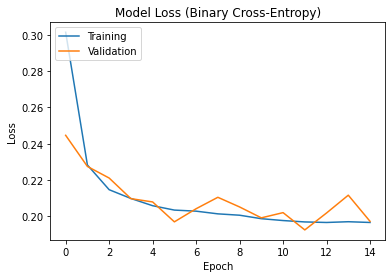

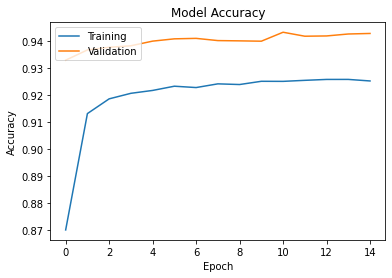

In [23]:
LR = 5e-4
training_epochs = 15
checkpoint_filepath = '/content/drive/MyDrive/IE643/best_model_col_deepest/best_model_weights'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True)

K.clear_session()
model = create_model_col_conv_deepest()
print()
print('Learning Rate = ', LR)
print('Training Epochs = ', training_epochs)
print('==================================================================================================')
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print()
history = model.fit(train_inps, train_ops, epochs=training_epochs, batch_size=32, verbose=1, validation_data=(val_inps, val_ops), callbacks=[checkpoint_callback])
print()
print()

# print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (Binary Cross-Entropy)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

print()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

# best_model = model
# best_model.save_weights('/content/drive/MyDrive/IE643/best_model_colbert_conv/best_model_weights')

# Create a new model instance
# model_new = create_model()
# Restore the weights
# model.load_weights(checkpoint_filepath)
# model_new.load_weights('/content/drive/MyDrive/IE643/best_model_weights')

### Validation

In [ ]:
valid_preds = []
valid_preds.append(model.predict(val_inps))
acc = print_evaluation_metrics(np.array(val_ops), np.array(valid_preds[-1]), is_regression=True)

#best_model.save('/content/drive/MyDrive/IE643/')
# model = keras.models.load_model('path/to/location')

In [ ]:
len(val_inps[0])

In [ ]:
print(val_ops.shape, valid_preds[-1].shape)